#### **Task**

- Implement more rigorous definition for low activity
    - Sedentary is defined as <500 counts/min for over 10.6 hours/day
- Medication, chronic illness, disease (hypertension)
- Comorbidities
    - C-Reactive Protein (normal is < 1): CRP/L11 file, LBXCRP (valid values range 0.02 to 17.5)
    - Blood Pressure (high BP is 120+ systolic pressure OR 80+ diastolic pressure): BPX file, BPXSY1 and BPXDI1 (valid values are != .)
    - Resting heart rate (normal is 60-100): BPX file, BPXPLS (60 sec pulse) (valid values are != .)
    - Glycohemoglobin (normal is < 5.7): GHB/L10 file, LBXGH (valid values are != .)
    - LDL (normal is <100): TRIGLY/L13AM file, LBDLDL (valid values are != .)
        - ~50% of data missing, so won't use this for now
- At least 1 risk factor = unhealthy
- Re run models after removing additional unhealthy participants from current healthy participants


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy import stats

In [2]:
# First, let's bring in the SEQN's for participants we have embeddings for.
seqns = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_accel_embedding_gpt50.csv").SEQN

In [3]:
# Bring in comorbidity data.
# 1. LDL
ldl1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/TRIGLY_D.csv")[['SEQN', 'LBDLDL']]
ldl2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/L13AM_C.csv")[['SEQN', 'LBDLDL']]

ldl = pd.concat([ldl1, ldl2])

# 2. CRP
crp1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/CRP_D.csv")[['SEQN', 'LBXCRP']]
crp2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/L11_C.csv")[['SEQN', 'LBXCRP']]

crp = pd.concat([crp1, crp2])

# 3. BP
bp1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/BPX_D.csv")[['SEQN', 'BPXSY1', 'BPXDI1', 'BPXPLS']]
bp2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/BPX_C.csv")[['SEQN', 'BPXSY1', 'BPXDI1', 'BPXPLS']]

bp = pd.concat([bp1, bp2])

# 4. A1C
a1c1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/GHB_D.csv")[['SEQN', 'LBXGH']]
a1c2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/L10_C.csv")[['SEQN', 'LBXGH']]

a1c = pd.concat([a1c1, a1c2])

In [4]:
# Merge all comorbidity data
comorb_df = ldl.merge(crp, on='SEQN', how='outer')\
               .merge(bp, on='SEQN', how='outer')\
               .merge(a1c, on='SEQN', how='outer')

In [35]:
# Only keep comorbidity data for participants with embedding data
comorb_df = comorb_df[comorb_df['SEQN'].isin(seqns)]

In [36]:
# Calculate percentage of non-missing values
non_missing_percentages = (comorb_df.count() / len(comorb_df)) * 100

print(f"\nPercentage of non-missing values per column:\n{non_missing_percentages.round(2)}")


Percentage of non-missing values per column:
SEQN      100.00
LBDLDL     43.86
LBXCRP     96.05
BPXSY1     85.55
BPXDI1     85.55
BPXPLS     96.73
LBXGH      96.41
dtype: float64


In [40]:
comorb_df = comorb_df[comorb_df['LBXCRP'] != 0.01]
comorb_df = comorb_df.dropna().drop(columns=['LBDLDL'])

In [42]:
# Find healthy participants
healthy_participants = comorb_df[
    (comorb_df['LBXCRP'] > 0.01) & 
    (comorb_df['LBXCRP'] < 1) & 
    (comorb_df['BPXSY1'] < 120) & 
    (comorb_df['BPXDI1'] < 80) & 
    (comorb_df['LBXGH'] < 6) &
    (comorb_df['BPXPLS'] > 59 ) &
    (comorb_df['BPXPLS'] < 101 )
]

In [43]:
# Healthy participants' SEQN
healthy_seqn = healthy_participants.SEQN

In [44]:
# Unhealthy participants' SEQN
unhealthy_participants = comorb_df[~comorb_df['SEQN'].isin(healthy_seqn)].dropna()
unhealthy_participants = unhealthy_participants[unhealthy_participants['LBXCRP'] != 0.01]

unhealthy_seqn = unhealthy_participants.SEQN

In [45]:
unhealthy_participants['n_risk'] = (
    (unhealthy_participants['LBXCRP'] >= 1).astype(int) +     # CRP too high
    (unhealthy_participants['BPXSY1'] >= 120).astype(int) +   # High systolic BP
    (unhealthy_participants['BPXDI1'] >= 80).astype(int) +    # High diastolic BP
    (unhealthy_participants['LBXGH'] >= 6).astype(int) +    # High A1C
    ((unhealthy_participants['BPXPLS'] <= 59) | (unhealthy_participants['BPXPLS'] >= 100)).astype(int)    # Abnormal pulse
)

In [21]:
# Bring in embeddings, clean up, and standardize
# 1. GPT50 on Raw Accelerometer Data
gpt50_raw = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_accel_embedding_gpt50.csv")
columns_to_exclude = ['Education', 'Married', 'BMI', 'combined', 'n_tokens', 'Age', 'PAD590', 'TV_Risk', 'Activity_Risk', 'BMI_Risk']
gpt50 = gpt50_raw[[col for col in gpt50_raw.columns if col not in columns_to_exclude]].rename(columns={'RIDAGEYR': 'Age', 'BMXBMI': 'BMI'})

# 2. GPT1536 on Raw Accelerometer Data
gpt1536 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_wide_embedding_gpt1536_clean.csv")
gpt1536 = gpt1536.merge(
    gpt50_raw[['SEQN', 'BMXBMI']], 
    on='SEQN', 
    how='left'
).drop(columns=['BMI', 'Unnamed: 0', 'Married', 'Education'], errors='ignore').rename(columns={'BMXBMI': 'BMI'})
var_columns = [col for col in gpt1536.columns if col.startswith('var')]
rename_dict = {col: col.replace('var', '') for col in var_columns}
gpt1536 = gpt1536.rename(columns=rename_dict)

# 3. GPT50 on Occupation Time Curve Data
gpt50_otc = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_otc_correct_embedding_gpt50.csv")
gpt50_otc = gpt50_otc.merge(
    gpt50_raw[['SEQN', 'Gender', 'Race', 'PIR', 'BMXBMI', 'Age']], 
    on='SEQN', 
    how='left'
).rename(columns={'BMXBMI': 'BMI'})

# GPT1536 on Occupation Time Curve
gpt1536_otc = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_otc_correct_embedding_gpt1536.csv")
gpt1536_otc = gpt1536_otc.merge(
    gpt50_raw[['SEQN', 'Gender', 'Race', 'PIR', 'BMXBMI', 'Age']], 
    on='SEQN', 
    how='left'
).rename(columns={'BMXBMI': 'BMI'})

In [22]:
df_50 = {'GPT50 Raw Accelerometer': gpt50,
       'GPT50 OTC': gpt50_otc}

df_1536 = {'GPT1536 Raw Accelerometer': gpt1536,
           'GPT1536 OTC': gpt1536_otc}

### Train on Healthy, Predict on Unhealthy

GPT50 Raw Accelerometer
RMSE for test set (healthy participants): 14.73
R Squared for test set (healthy participants): 0.43


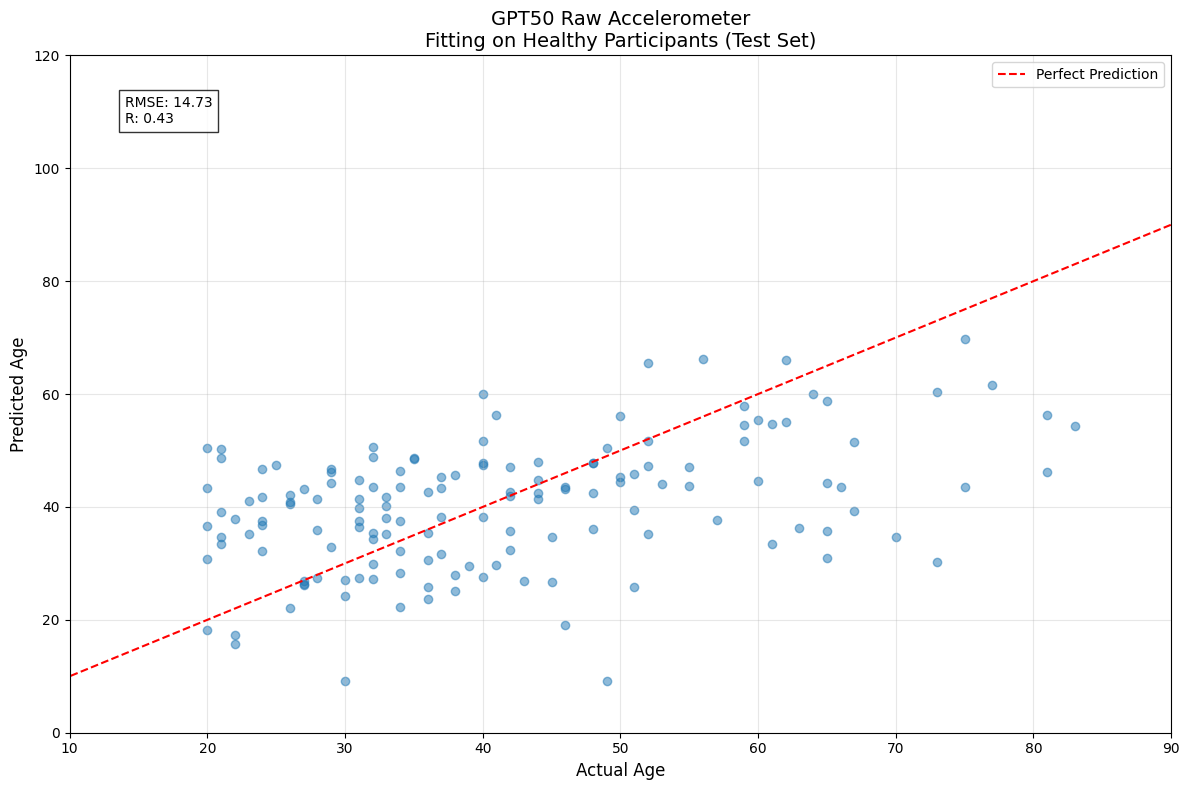


Prediction Statistics:
Mean Absolute Error: 11.57
Mean prediction: 40.35
Mean actual age: 41.45
Age range in test set: 20 to 83



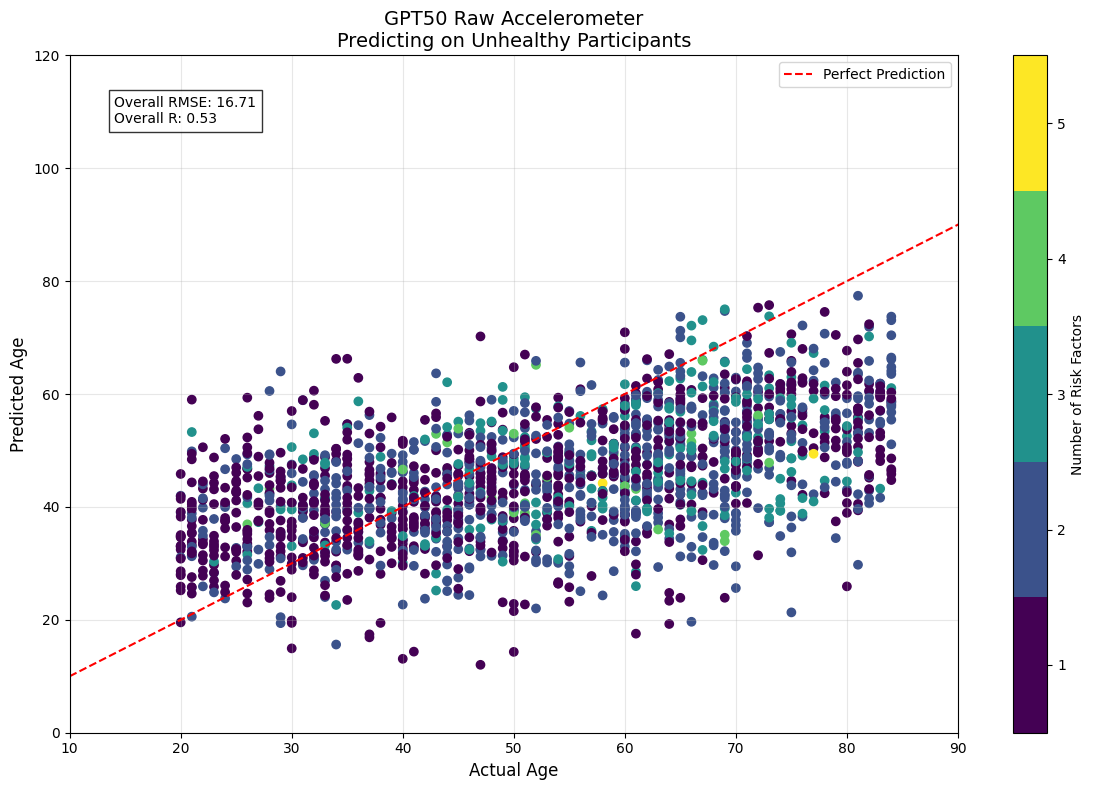

Percentage of unhealthy participants with higher prediction than actual age: 30.42%
GPT50 OTC
RMSE for test set (healthy participants): 14.15
R Squared for test set (healthy participants): 0.42


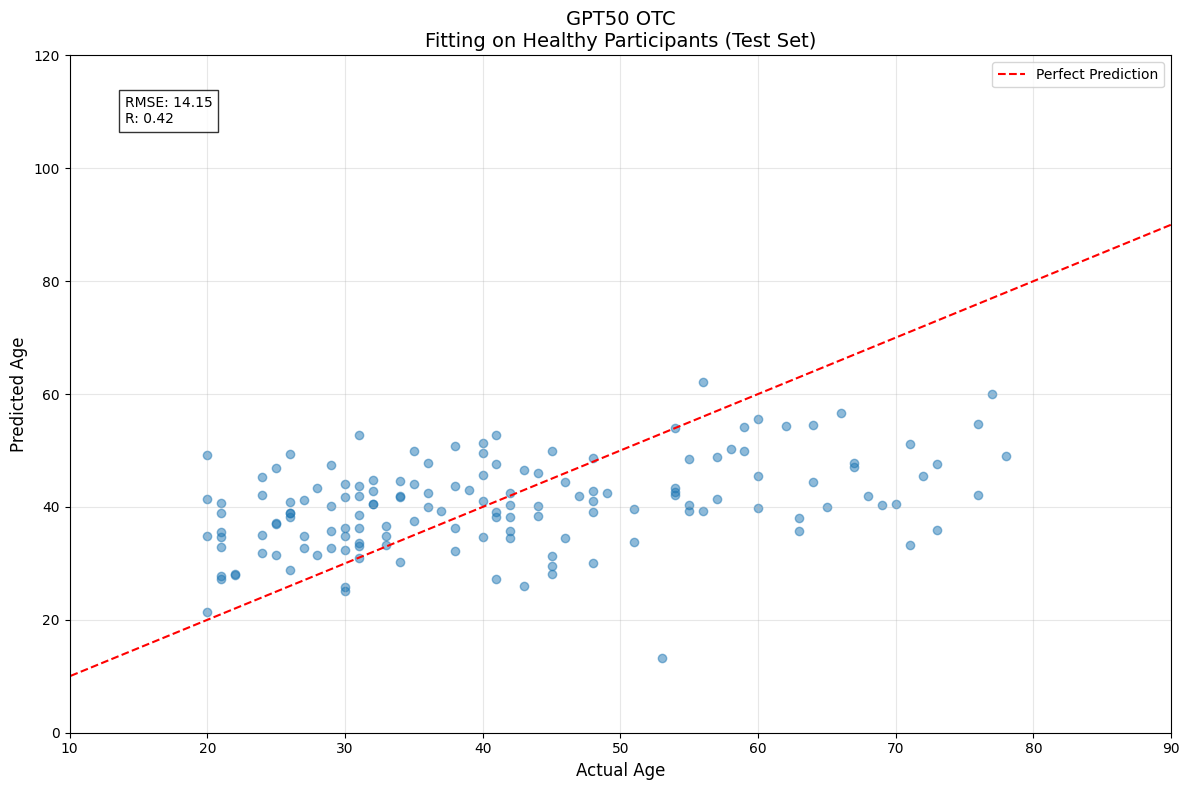


Prediction Statistics:
Mean Absolute Error: 11.43
Mean prediction: 40.38
Mean actual age: 41.57
Age range in test set: 20 to 78



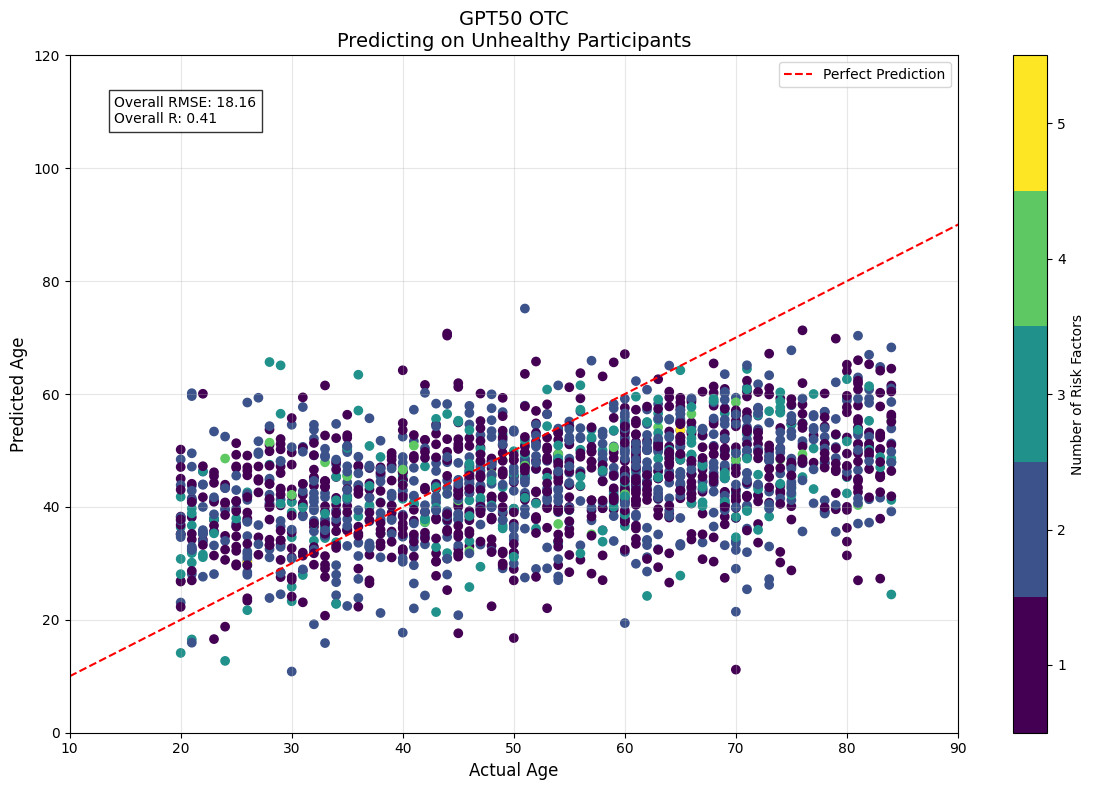

Percentage of unhealthy participants with higher prediction than actual age: 29.98%


In [114]:
for name, data in df_50.items():
    healthy = data[data['SEQN'].isin(healthy_seqn)]
    X = healthy.drop(columns=["Age", 'SEQN'], errors="ignore")
    y = healthy["Age"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_scaler = StandardScaler()

    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    lr_gpt50 = LinearRegression()
    lr_gpt50.fit(X_train_scaled, y_train)
    y_pred_gpt50 = lr_gpt50.predict(X_test_scaled)
    rmse_gpt50 = np.sqrt(mean_squared_error(y_test, y_pred_gpt50))
    r_gpt50 = stats.pearsonr(y_test, y_pred_gpt50)[0]

    print(name)
    print(f"RMSE for test set (healthy participants): {rmse_gpt50:.2f}")
    print(f"R Squared for test set (healthy participants): {r_gpt50:.2f}")

    plt.figure(figsize=(12, 8))
    plt.scatter(y_test, y_pred_gpt50, alpha=0.5)
    plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')
    plt.xlim(10, 90)
    plt.ylim(0, 120)
    plt.xlabel('Actual Age', fontsize=12)
    plt.ylabel('Predicted Age', fontsize=12)
    plt.title(f'{name}\nFitting on Healthy Participants (Test Set)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    metrics_text = f'RMSE: {rmse_gpt50:.2f}\nR: {r_gpt50:.2f}'
    plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nPrediction Statistics:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_gpt50):.2f}")
    print(f"Mean prediction: {y_pred_gpt50.mean():.2f}")
    print(f"Mean actual age: {y_test.mean():.2f}")
    print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}\n")

    unhealthy_gpt50 = data[data['SEQN'].isin(unhealthy_seqn)]
    X_unhealthy = unhealthy_gpt50.drop(columns=['Age', 'SEQN'], errors='ignore')
    X_unhealthy = X_unhealthy[X_train.columns]
    y_unhealthy = unhealthy_gpt50['Age'].reset_index(drop=True)

    X_unhealthy_scaled = X_scaler.transform(X_unhealthy)
    X_unhealthy_scaled = pd.DataFrame(X_unhealthy_scaled, columns=X_unhealthy.columns)

    y_pred_gpt50_unhealthy = lr_gpt50.predict(X_unhealthy_scaled)

    rmse_unhealthy_gpt50 = np.sqrt(mean_squared_error(y_unhealthy, y_pred_gpt50_unhealthy))
    r_unhealthy_gpt50 = stats.pearsonr(y_unhealthy, y_pred_gpt50_unhealthy)[0]
    plt.figure(figsize=(12, 8))
        
    plt.plot([10, 120], [10, 120], 'r--', label='Perfect Prediction')
    plt.xlim(10, 90)
    plt.ylim(0, 120)
    scatter = plt.scatter(y_unhealthy, y_pred_gpt50_unhealthy,c=unhealthy_participants['n_risk'])
    plt.xlabel('Actual Age', fontsize=12)
    plt.ylabel('Predicted Age', fontsize=12)
    plt.title(f'{name}\nPredicting on Unhealthy Participants', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    max_risk = int(unhealthy_participants['n_risk'].max())
    cbar = plt.colorbar(scatter, 
                    label='Number of Risk Factors',
                    boundaries=np.arange(0.5, max_risk + 1.5, 1),
                    ticks=np.arange(0, max_risk + 1, 1))

    plt.tight_layout()
    # Add overall metrics text
    metrics_text = f'Overall RMSE: {rmse_unhealthy_gpt50:.2f}\nOverall R: {r_unhealthy_gpt50:.2f}'
    plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    plt.show()
    print(f"Percentage of unhealthy participants with higher prediction than actual age: {((y_pred_gpt50_unhealthy > y_unhealthy).mean()):.2%}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


GPT1536 Raw Accelerometer
RMSE for test set (healthy participants): 13.33
R Squared for test set (healthy participants): 0.54


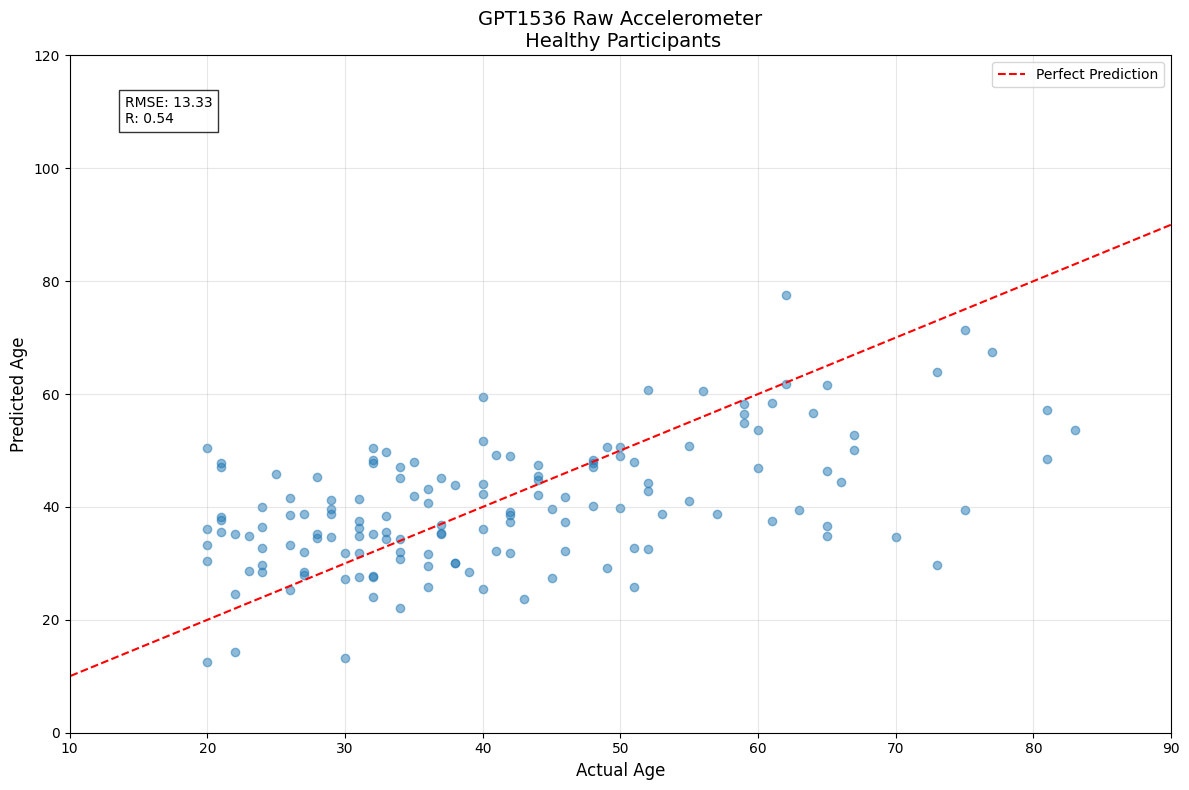


Prediction Statistics:
Mean Absolute Error: 10.28
Mean prediction: 40.16
Mean actual age: 41.45
Age range in test set: 20 to 83



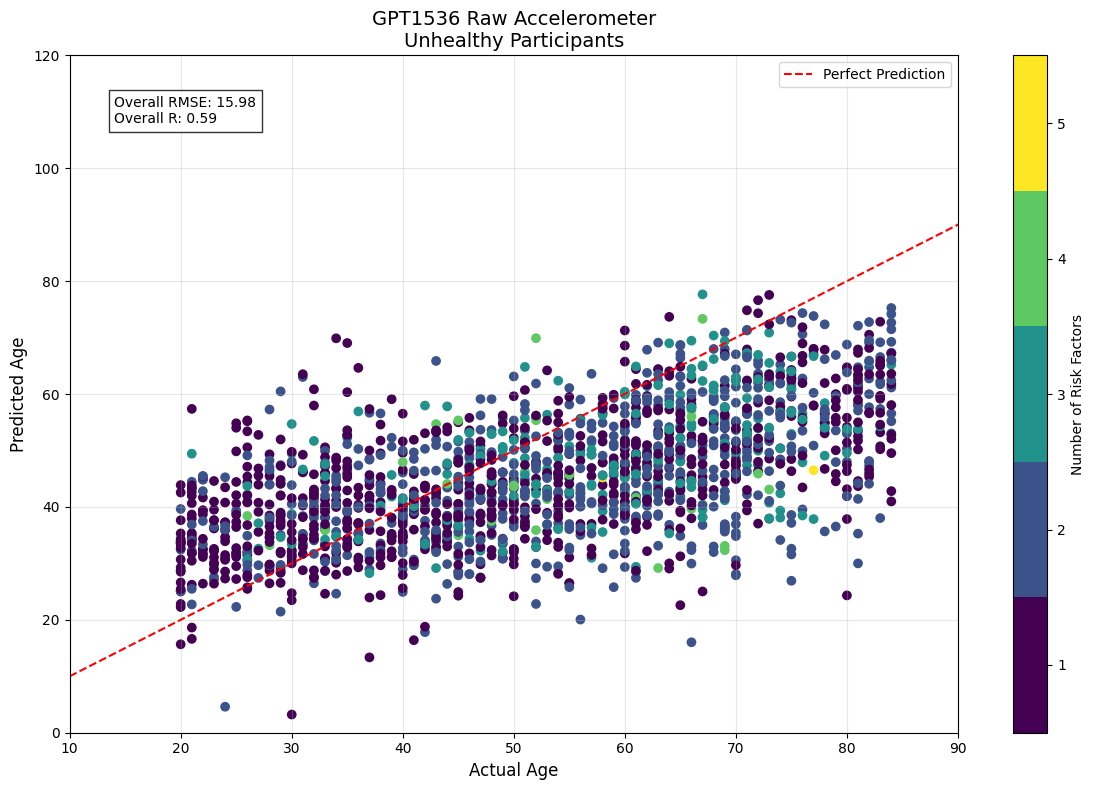

Percentage of unhealthy participants with higher prediction than actual age: 30.81%
GPT1536 OTC
RMSE for test set (healthy participants): 14.28
R Squared for test set (healthy participants): 0.39


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


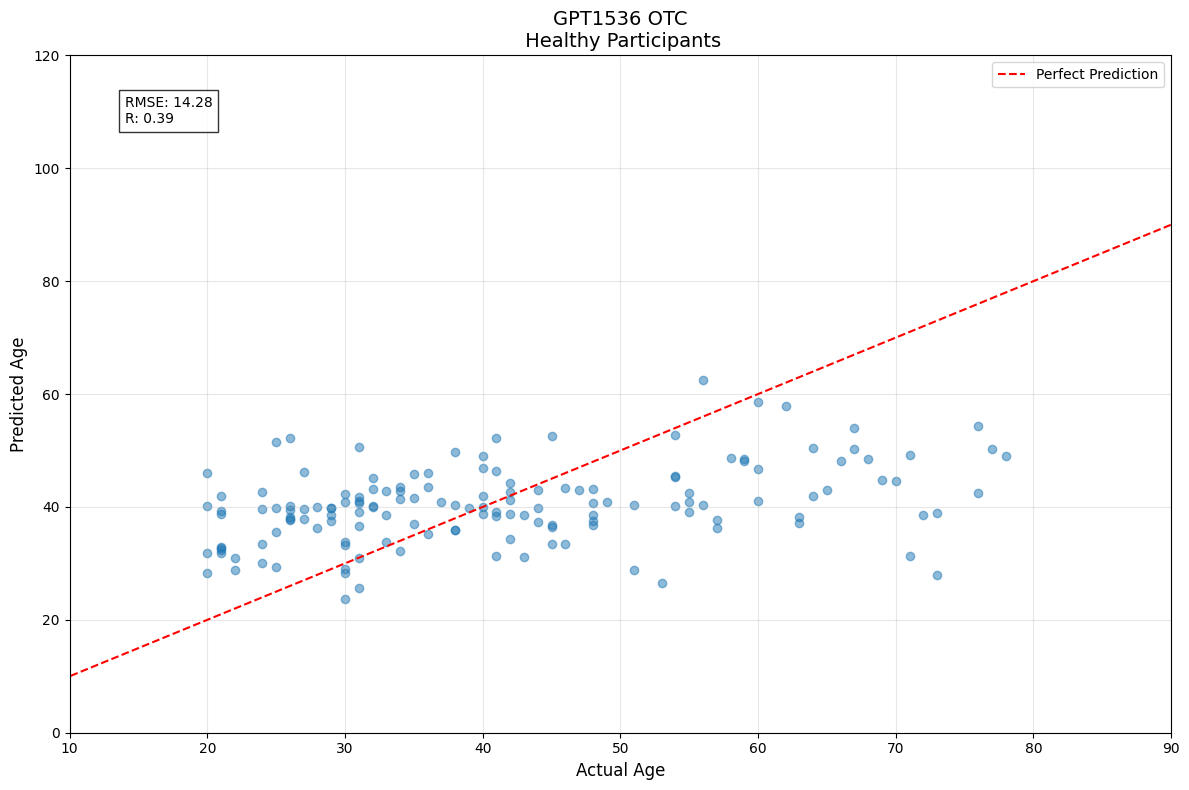


Prediction Statistics:
Mean Absolute Error: 11.55
Mean prediction: 40.37
Mean actual age: 41.57
Age range in test set: 20 to 78



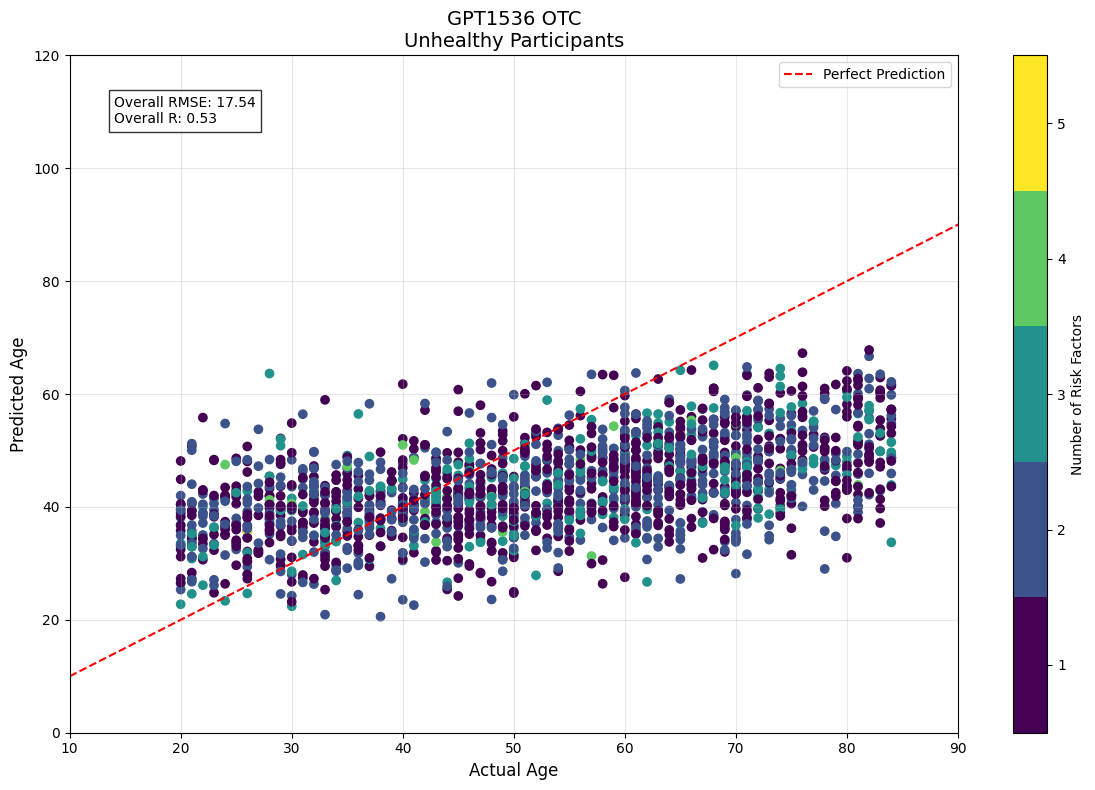

Percentage of unhealthy participants with higher prediction than actual age: 28.28%


In [65]:
for name, data in df_1536.items():
    healthy = data[data['SEQN'].isin(healthy_seqn)]
    X = healthy.drop(columns=["Age", 'SEQN'], errors="ignore")
    y = healthy["Age"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_scaler = StandardScaler()

    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    ridge_1536 = RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True)
    ridge_1536.fit(X_train_scaled, y_train)
    y_pred_gpt1536 = ridge_1536.predict(X_test_scaled)
    rmse_gpt1536 = np.sqrt(mean_squared_error(y_test, y_pred_gpt1536))
    r_gpt1536 = stats.pearsonr(y_test, y_pred_gpt1536)[0]

    print(name)
    print(f"RMSE for test set (healthy participants): {rmse_gpt1536:.2f}")
    print(f"R Squared for test set (healthy participants): {r_gpt1536:.2f}")

    plt.figure(figsize=(12, 8))
    plt.scatter(y_test, y_pred_gpt1536, alpha=0.5)
    plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')
    plt.xlim(10, 90)
    plt.ylim(0, 120)
    plt.xlabel('Actual Age', fontsize=12)
    plt.ylabel('Predicted Age', fontsize=12)
    plt.title(f'{name}\n Healthy Participants', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    metrics_text = f'RMSE: {rmse_gpt1536:.2f}\nR: {r_gpt1536:.2f}'
    plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nPrediction Statistics:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_gpt1536):.2f}")
    print(f"Mean prediction: {y_pred_gpt1536.mean():.2f}")
    print(f"Mean actual age: {y_test.mean():.2f}")
    print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}\n")

    unhealthy_gpt1536 = data[data['SEQN'].isin(unhealthy_seqn)]
    X_unhealthy = unhealthy_gpt1536.drop(columns=['Age', 'SEQN'], errors='ignore')
    X_unhealthy = X_unhealthy[X_train.columns]
    y_unhealthy = unhealthy_gpt1536['Age'].reset_index(drop=True)

    X_unhealthy_scaled = X_scaler.transform(X_unhealthy)
    X_unhealthy_scaled = pd.DataFrame(X_unhealthy_scaled, columns=X_unhealthy.columns)

    y_pred_gpt1536_unhealthy = ridge_1536.predict(X_unhealthy_scaled)

    rmse_unhealthy_gpt1536 = np.sqrt(mean_squared_error(y_unhealthy, y_pred_gpt1536_unhealthy))
    r_unhealthy_gpt1536 = stats.pearsonr(y_unhealthy, y_pred_gpt1536_unhealthy)[0]
    plt.figure(figsize=(12, 8))
        
    plt.plot([10, 120], [10, 120], 'r--', label='Perfect Prediction')
    plt.xlim(10, 90)
    plt.ylim(0, 120)
    scatter = plt.scatter(y_unhealthy, y_pred_gpt1536_unhealthy,c=unhealthy_participants['n_risk'])
    plt.xlabel('Actual Age', fontsize=12)
    plt.ylabel('Predicted Age', fontsize=12)
    plt.title(f'{name}\nUnhealthy Participants', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    max_risk = int(unhealthy_participants['n_risk'].max())
    cbar = plt.colorbar(scatter, 
                    label='Number of Risk Factors',
                    boundaries=np.arange(0.5, max_risk + 1.5, 1),
                    ticks=np.arange(0, max_risk + 1, 1))

    plt.tight_layout()
    # Add overall metrics text
    metrics_text = f'Overall RMSE: {rmse_unhealthy_gpt1536:.2f}\nOverall R: {r_unhealthy_gpt1536:.2f}'
    plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    plt.show()
    print(f"Percentage of unhealthy participants with higher prediction than actual age: {((y_pred_gpt1536_unhealthy > y_unhealthy).mean()):.2%}")

### Train on Unhealthy, Predict on Healthy

GPT50 Raw Accelerometer
RMSE for test set (unhealthy participants): 13.48
R Squared for test set (unhealthy participants): 0.63


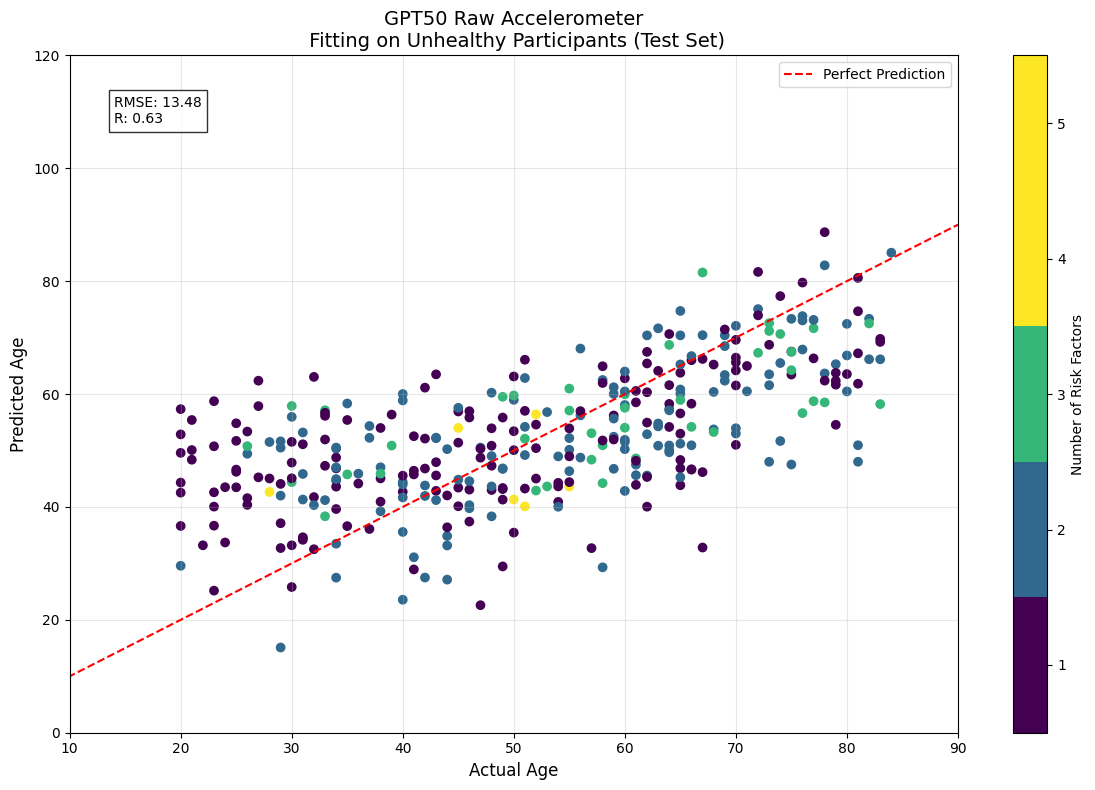


Prediction Statistics:
Mean Absolute Error: 10.77
Mean prediction: 52.65
Mean actual age: 52.19
Age range in test set: 20 to 84



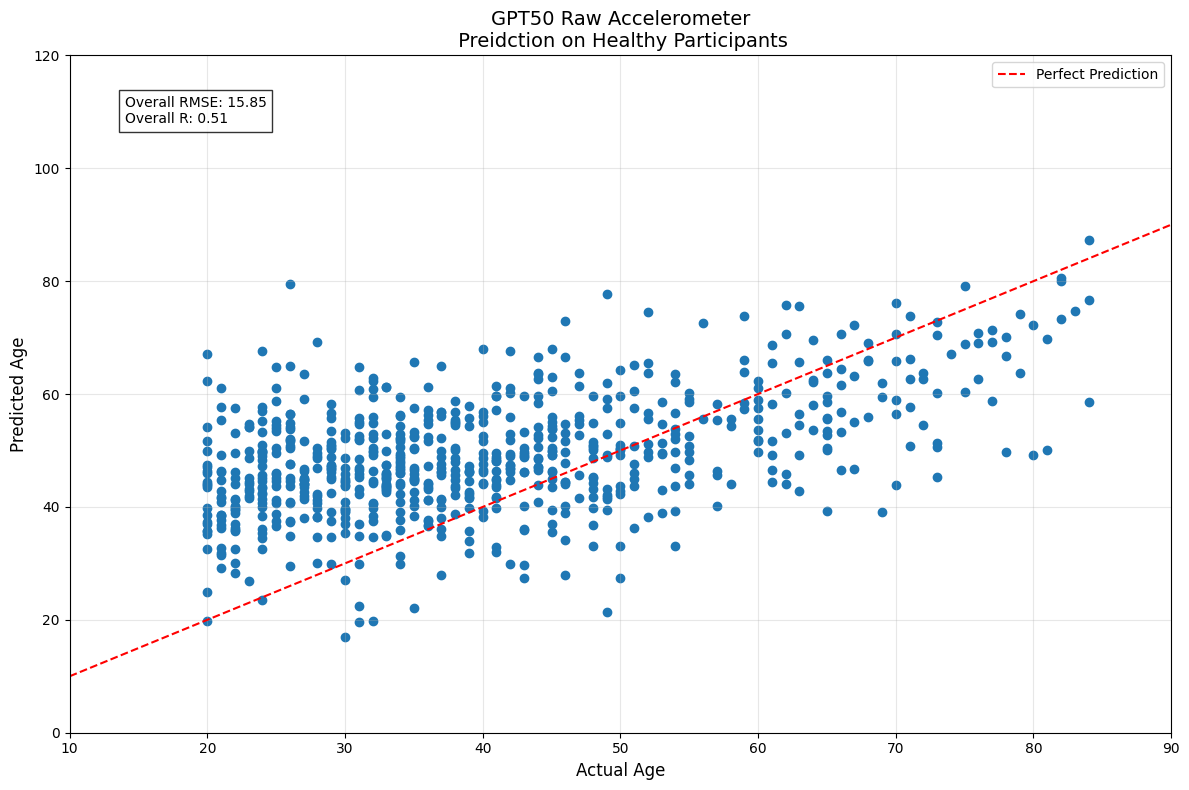

Percentage of healthy participants with lower prediction than actual age: 29.08%
GPT50 OTC
RMSE for test set (unhealthy participants): 15.71
R Squared for test set (unhealthy participants): 0.43


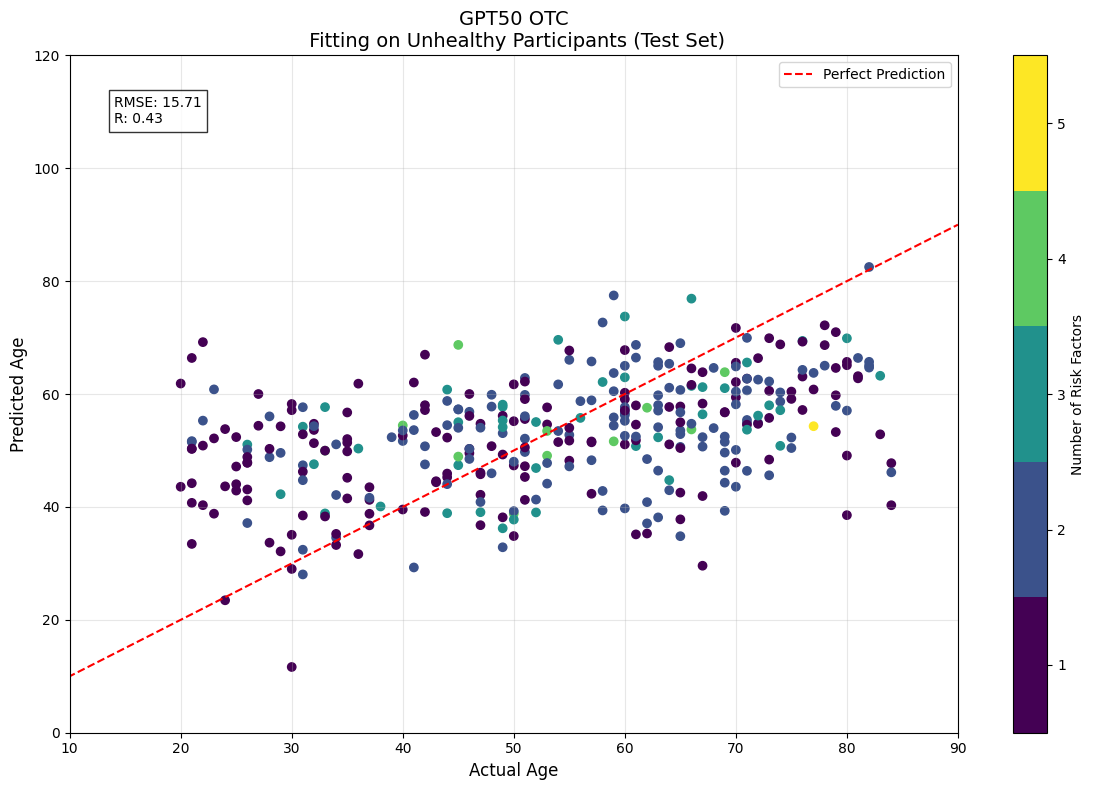


Prediction Statistics:
Mean Absolute Error: 12.68
Mean prediction: 52.71
Mean actual age: 53.19
Age range in test set: 20 to 84



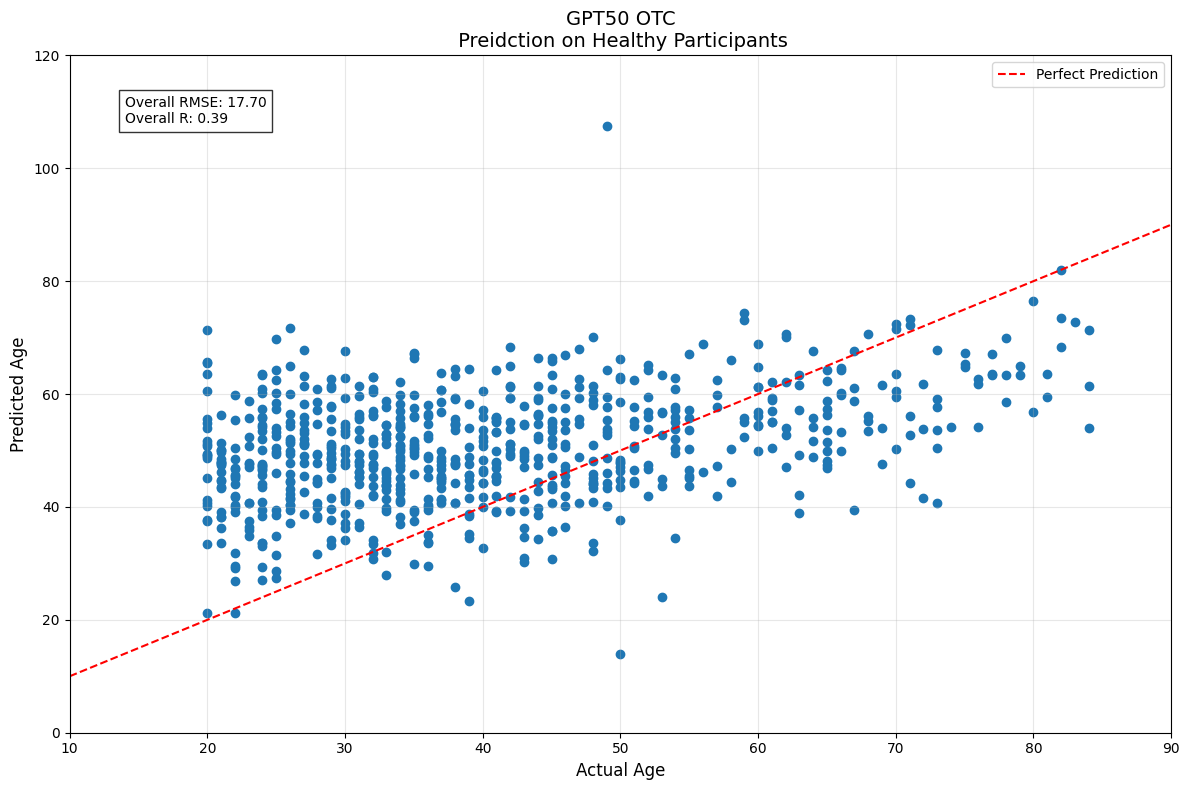

Percentage of healthy participants with lower prediction than actual age: 25.82%


In [111]:
for name, data in df_50.items():
    unhealthy = data[data['SEQN'].isin(unhealthy_seqn)]
    X = unhealthy.drop(columns=["Age", 'SEQN'], errors="ignore")
    y = unhealthy["Age"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    test_seqns = unhealthy.loc[y_test.index]['SEQN']
    test_n_risk = unhealthy_participants.set_index('SEQN').loc[test_seqns, 'n_risk']

    X_scaler = StandardScaler()

    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    lr_gpt50 = LinearRegression()
    lr_gpt50.fit(X_train_scaled, y_train)
    y_pred_gpt50 = lr_gpt50.predict(X_test_scaled)
    rmse_gpt50 = np.sqrt(mean_squared_error(y_test, y_pred_gpt50))
    r_gpt50 = stats.pearsonr(y_test, y_pred_gpt50)[0]

    print(name)
    print(f"RMSE for test set (unhealthy participants): {rmse_gpt50:.2f}")
    print(f"R Squared for test set (unhealthy participants): {r_gpt50:.2f}")

    plt.figure(figsize=(12, 8))

    scatter = plt.scatter(y_test, y_pred_gpt50, c=test_n_risk)
    plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')
    plt.xlim(10, 90)
    plt.ylim(0, 120)
    plt.xlabel('Actual Age', fontsize=12)
    plt.ylabel('Predicted Age', fontsize=12)
    plt.title(f'{name}\n Fitting on Unhealthy Participants (Test Set)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    cbar = plt.colorbar(scatter, 
                    label='Number of Risk Factors',
                    boundaries=np.arange(0.5, 5 + 1.5, 1),
                    ticks=np.arange(0, 5 + 1, 1))
    
    metrics_text = f'RMSE: {rmse_gpt50:.2f}\nR: {r_gpt50:.2f}'
    plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nPrediction Statistics:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_gpt50):.2f}")
    print(f"Mean prediction: {y_pred_gpt50.mean():.2f}")
    print(f"Mean actual age: {y_test.mean():.2f}")
    print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}\n")

    healthy_gpt50 = data[data['SEQN'].isin(healthy_seqn)]
    X_healthy = healthy_gpt50.drop(columns=['Age', 'SEQN'], errors='ignore')
    X_healthy = X_healthy[X_train.columns]
    y_healthy = healthy_gpt50['Age'].reset_index(drop=True)

    X_healthy_scaled = X_scaler.transform(X_healthy)
    X_healthy_scaled = pd.DataFrame(X_healthy_scaled, columns=X_healthy.columns)

    y_pred_gpt50_healthy = lr_gpt50.predict(X_healthy_scaled)

    rmse_healthy_gpt50 = np.sqrt(mean_squared_error(y_healthy, y_pred_gpt50_healthy))
    r_healthy_gpt50 = stats.pearsonr(y_healthy, y_pred_gpt50_healthy)[0]
    plt.figure(figsize=(12, 8))
        
    plt.plot([10, 120], [10, 120], 'r--', label='Perfect Prediction')
    plt.xlim(10, 90)
    plt.ylim(0, 120)
    scatter = plt.scatter(y_healthy, y_pred_gpt50_healthy)
    plt.xlabel('Actual Age', fontsize=12)
    plt.ylabel('Predicted Age', fontsize=12)
    plt.title(f'{name}\n Preidction on Healthy Participants', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    

    plt.tight_layout()
    # Add overall metrics text
    metrics_text = f'Overall RMSE: {rmse_healthy_gpt50:.2f}\nOverall R: {r_healthy_gpt50:.2f}'
    plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    plt.show()
    print(f"Percentage of healthy participants with lower prediction than actual age: {((y_pred_gpt50_healthy < y_unhealthy).mean()):.2%}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


GPT1536 Raw Accelerometer
RMSE for test set (Unhealthy participants): 12.69
R Squared for test set (Unhealthy participants): 0.68


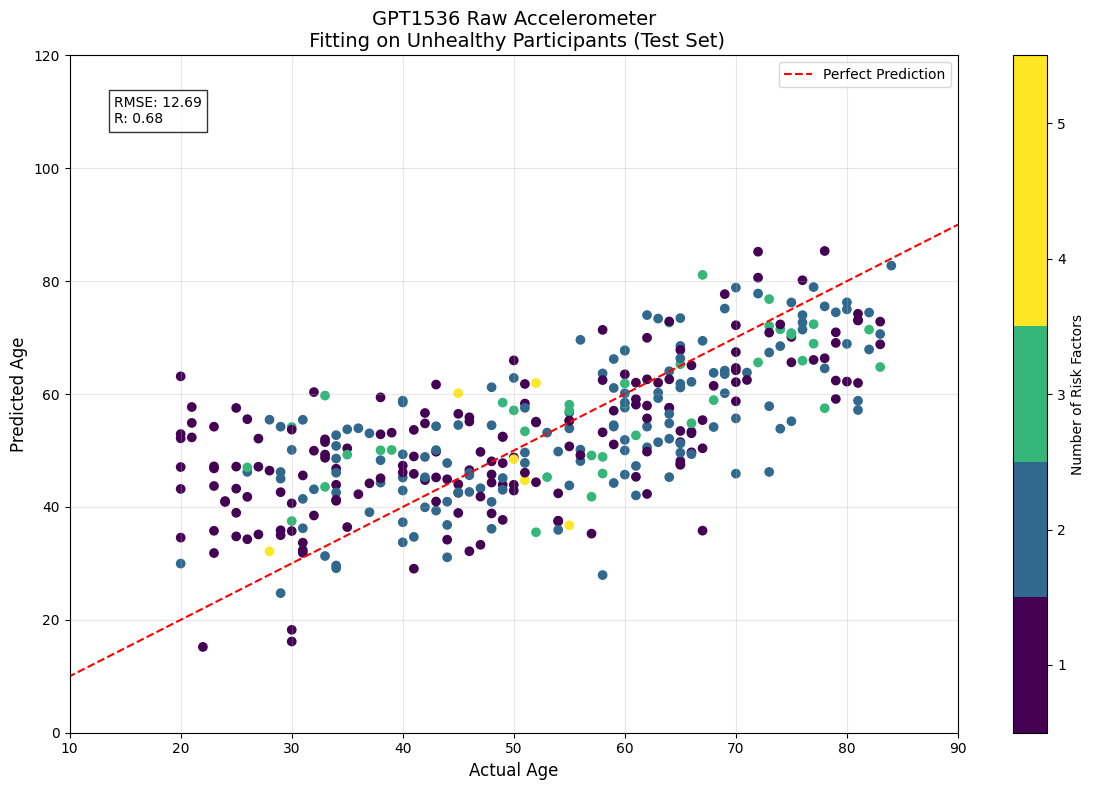


Prediction Statistics:
Mean Absolute Error: 10.15
Mean prediction: 53.18
Mean actual age: 52.19
Age range in test set: 20 to 84



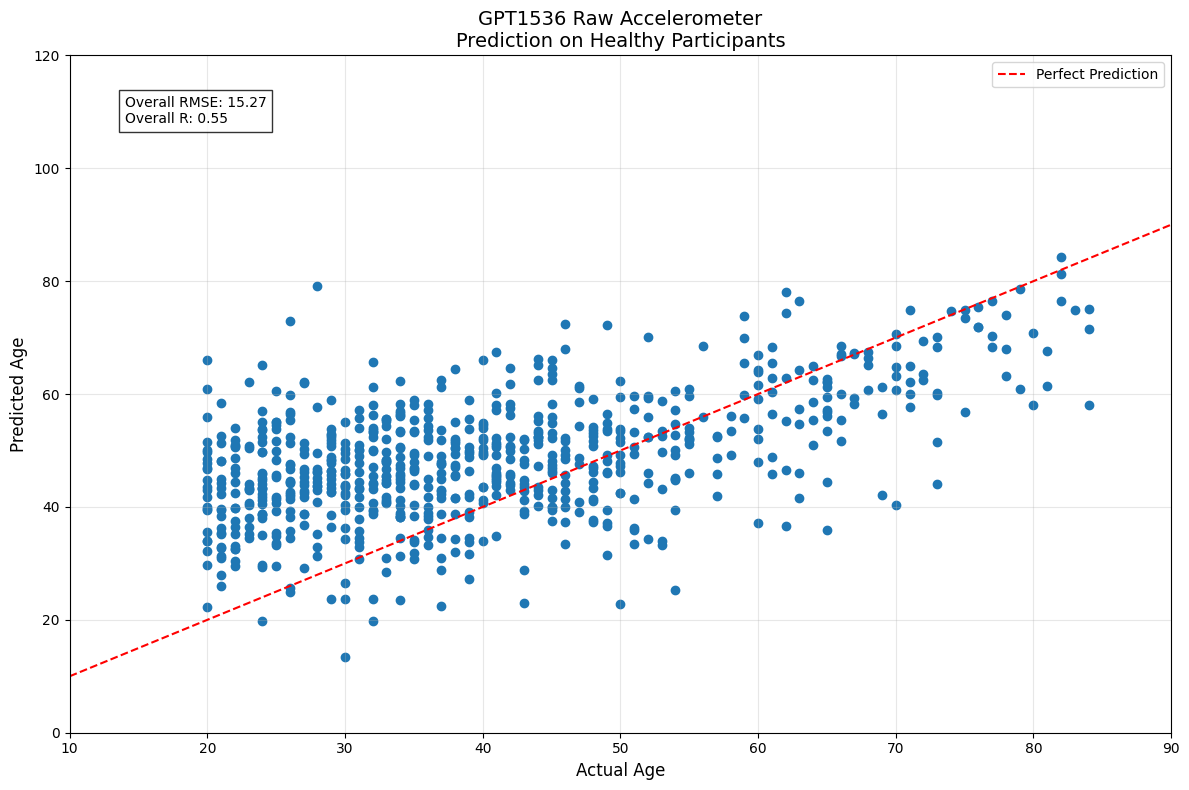

Percentage of healthy participants with lower prediction than actual age: 25.82%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


GPT1536 OTC
RMSE for test set (Unhealthy participants): 14.99
R Squared for test set (Unhealthy participants): 0.50


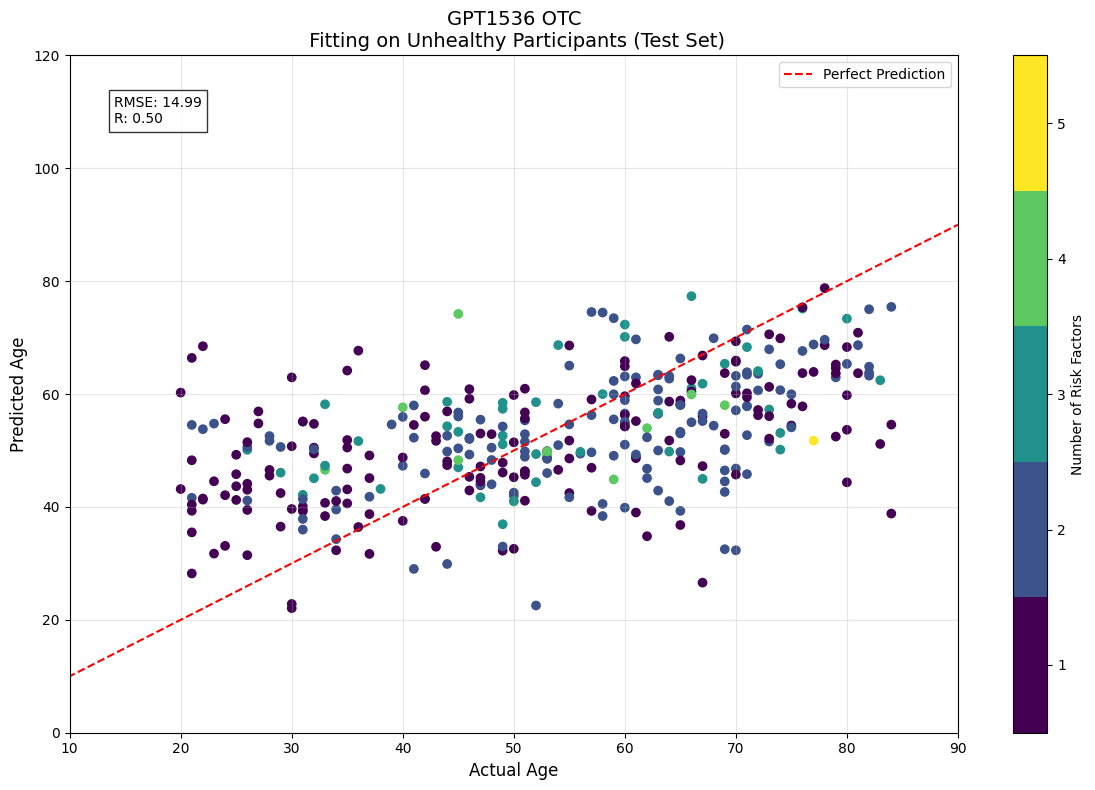


Prediction Statistics:
Mean Absolute Error: 12.03
Mean prediction: 52.41
Mean actual age: 53.19
Age range in test set: 20 to 84



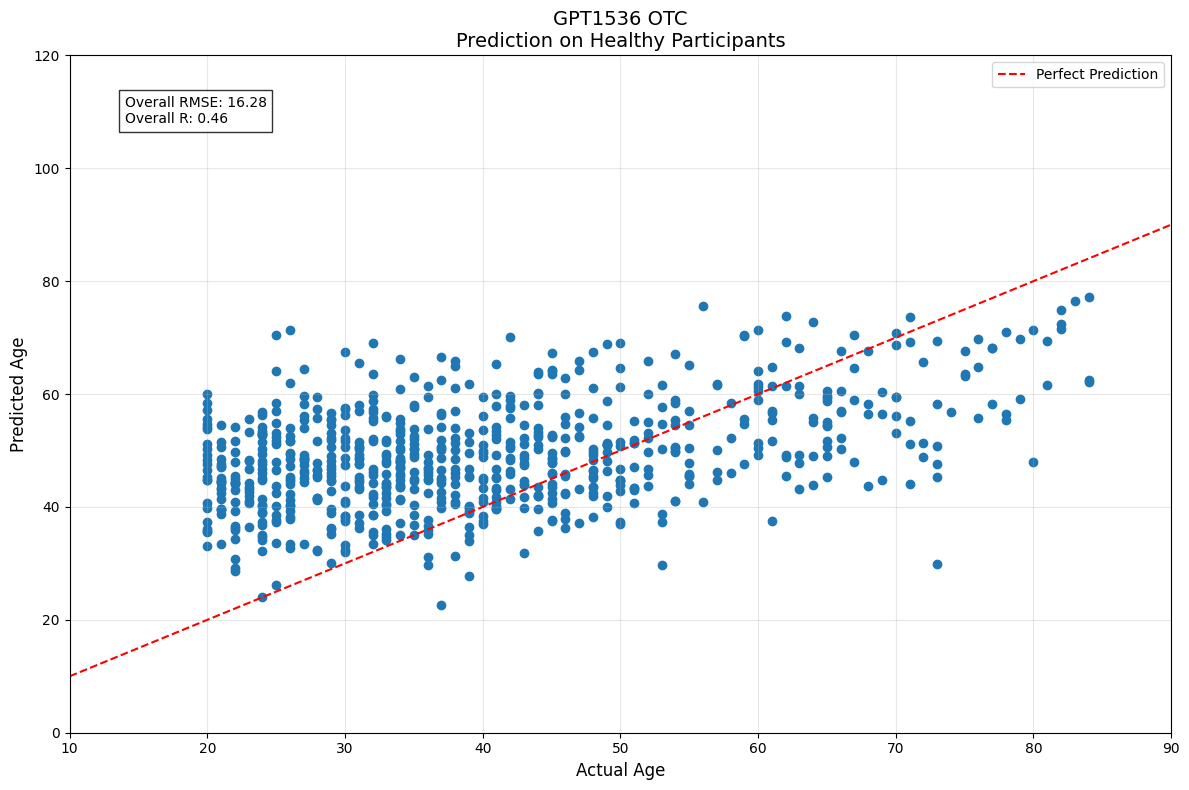

Percentage of healthy participants with lower prediction than actual age: 25.82%


In [112]:
for name, data in df_1536.items():
    unhealthy = data[data['SEQN'].isin(unhealthy_seqn)]
    X = unhealthy.drop(columns=["Age", 'SEQN'], errors="ignore")
    y = unhealthy["Age"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    test_seqns = unhealthy.loc[y_test.index]['SEQN']
    test_n_risk = unhealthy_participants.set_index('SEQN').loc[test_seqns, 'n_risk']

    X_scaler = StandardScaler()

    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    ridge_1536 = RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True)
    ridge_1536.fit(X_train_scaled, y_train)
    y_pred_gpt1536 = ridge_1536.predict(X_test_scaled)
    rmse_gpt1536 = np.sqrt(mean_squared_error(y_test, y_pred_gpt1536))
    r_gpt1536 = stats.pearsonr(y_test, y_pred_gpt1536)[0]

    print(name)
    print(f"RMSE for test set (Unhealthy participants): {rmse_gpt1536:.2f}")
    print(f"R Squared for test set (Unhealthy participants): {r_gpt1536:.2f}")

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(y_test, y_pred_gpt1536, c=test_n_risk)
    plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')
    plt.xlim(10, 90)
    plt.ylim(0, 120)
    plt.xlabel('Actual Age', fontsize=12)
    plt.ylabel('Predicted Age', fontsize=12)
    plt.title(f'{name}\n Fitting on Unhealthy Participants (Test Set)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    cbar = plt.colorbar(scatter, 
                    label='Number of Risk Factors',
                    boundaries=np.arange(0.5, 5 + 1.5, 1),
                    ticks=np.arange(0, 5 + 1, 1))
    metrics_text = f'RMSE: {rmse_gpt1536:.2f}\nR: {r_gpt1536:.2f}'
    plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nPrediction Statistics:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_gpt1536):.2f}")
    print(f"Mean prediction: {y_pred_gpt1536.mean():.2f}")
    print(f"Mean actual age: {y_test.mean():.2f}")
    print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}\n")

    healthy_gpt1536 = data[data['SEQN'].isin(healthy_seqn)]
    X_healthy = healthy_gpt1536.drop(columns=['Age', 'SEQN'], errors='ignore')
    X_healthy = X_healthy[X_train.columns]
    y_healthy = healthy_gpt1536['Age'].reset_index(drop=True)

    X_healthy_scaled = X_scaler.transform(X_healthy)
    X_healthy_scaled = pd.DataFrame(X_healthy_scaled, columns=X_healthy.columns)

    y_pred_gpt1536_healthy = ridge_1536.predict(X_healthy_scaled)

    rmse_healthy_gpt1536 = np.sqrt(mean_squared_error(y_healthy, y_pred_gpt1536_healthy))
    r_healthy_gpt1536 = stats.pearsonr(y_healthy, y_pred_gpt1536_healthy)[0]
    plt.figure(figsize=(12, 8))
        
    plt.plot([10, 120], [10, 120], 'r--', label='Perfect Prediction')
    plt.xlim(10, 90)
    plt.ylim(0, 120)
    scatter = plt.scatter(y_healthy, y_pred_gpt1536_healthy)
    plt.xlabel('Actual Age', fontsize=12)
    plt.ylabel('Predicted Age', fontsize=12)
    plt.title(f'{name}\nPrediction on Healthy Participants', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    # Add overall metrics text
    metrics_text = f'Overall RMSE: {rmse_healthy_gpt1536:.2f}\nOverall R: {r_healthy_gpt1536:.2f}'
    plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    plt.show()
    print(f"Percentage of healthy participants with lower prediction than actual age: {((y_pred_gpt50_healthy < y_unhealthy).mean()):.2%}")

### Mix Unhealthy and Healthy

Number of test set participants: 1389
Number of unhealthy participants: 1821
Number of test set participants that are unhealthy: 345
GPT50 Raw Accelerometer
RMSE for test set: 13.61
R Squared for test set: 0.64


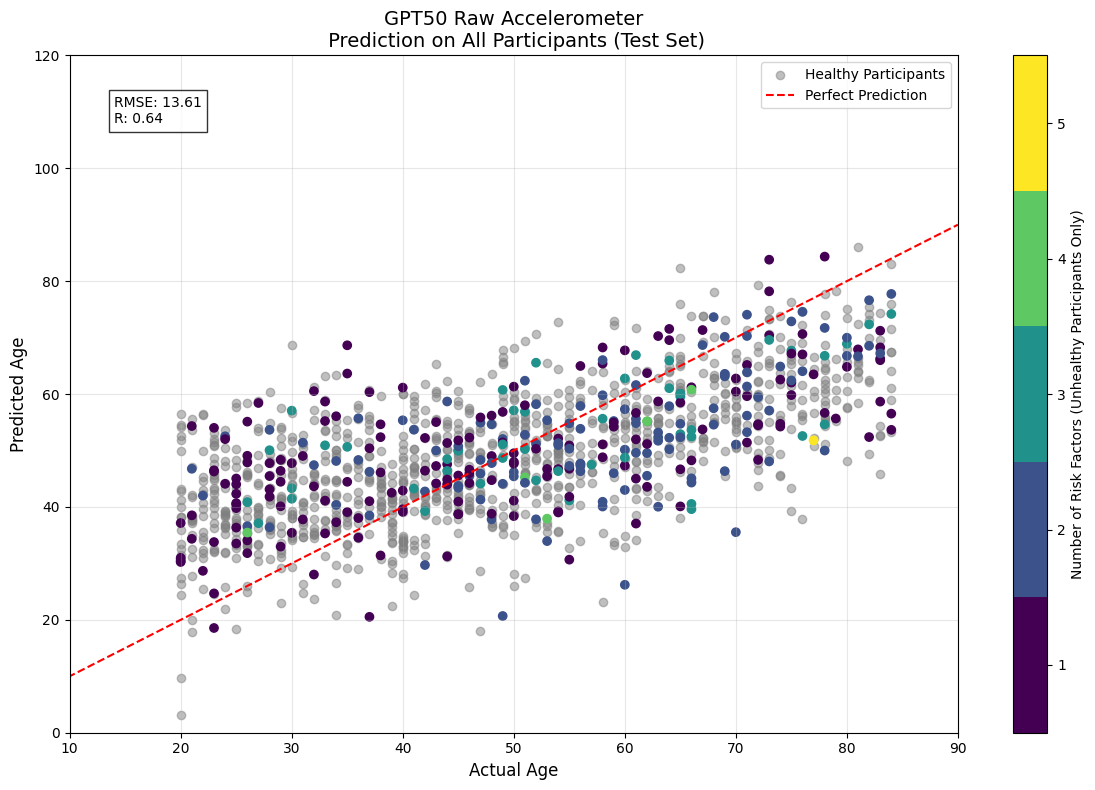


Prediction Statistics:
Mean Absolute Error: 11.06
Mean prediction: 49.05
Mean actual age: 48.68
Age range in test set: 20 to 84

Number of test set participants: 1389
Number of unhealthy participants: 1821
Number of test set participants that are unhealthy: 371
GPT50 OTC
RMSE for test set: 14.96
R Squared for test set: 0.53


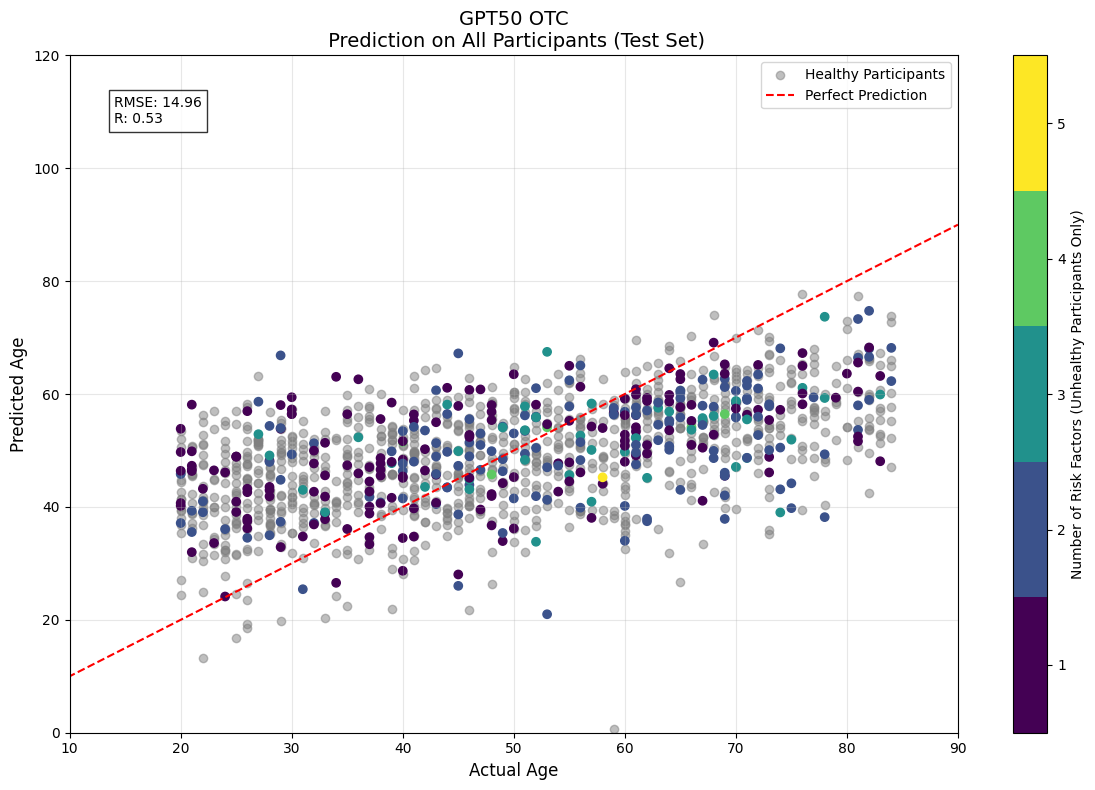


Prediction Statistics:
Mean Absolute Error: 12.37
Mean prediction: 49.35
Mean actual age: 49.39
Age range in test set: 20 to 84



In [113]:
for name, data in df_50.items():
    X = data.drop(columns=["Age", 'SEQN'], errors="ignore")
    y = data["Age"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Get test set SEQNs
    test_seqns = data.loc[y_test.index, 'SEQN']
    
    # Debug prints
    print(f"Number of test set participants: {len(test_seqns)}")
    print(f"Number of unhealthy participants: {len(unhealthy_participants)}")
    
    # Check how many test set participants are in unhealthy_participants
    matching_seqns = test_seqns[test_seqns.isin(unhealthy_participants['SEQN'])]
    print(f"Number of test set participants that are unhealthy: {len(matching_seqns)}")
    
    # Get n_risk values only for the matching SEQNs
    test_n_risk = pd.Series(index=y_test.index, data=np.nan)
    unhealthy_n_risk = unhealthy_participants.set_index('SEQN')['n_risk']
    test_n_risk.loc[matching_seqns.index] = matching_seqns.map(unhealthy_n_risk)

    X_scaler = StandardScaler()

    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    lr_gpt50 = LinearRegression()
    lr_gpt50.fit(X_train_scaled, y_train)
    y_pred_gpt50 = lr_gpt50.predict(X_test_scaled)
    rmse_gpt50 = np.sqrt(mean_squared_error(y_test, y_pred_gpt50))
    r_gpt50 = stats.pearsonr(y_test, y_pred_gpt50)[0]

    print(name)
    print(f"RMSE for test set: {rmse_gpt50:.2f}")
    print(f"R Squared for test set: {r_gpt50:.2f}")

    plt.figure(figsize=(12, 8))

    # Create scatter plot with colors from n_risk
    # First plot healthy participants (NaN values) in gray
    healthy_mask = test_n_risk.isna()
    plt.scatter(y_test[healthy_mask], y_pred_gpt50[healthy_mask], 
               alpha=0.5, c='gray', label='Healthy Participants')
    
    # Then plot unhealthy participants with n_risk colors
    unhealthy_mask = ~healthy_mask
    scatter = plt.scatter(y_test[unhealthy_mask], y_pred_gpt50[unhealthy_mask], 
                        c=test_n_risk[unhealthy_mask], 
                         cmap='viridis')
    
    plt.colorbar(scatter, label='Number of Risk Factors (Unhealthy Participants Only)',boundaries=np.arange(0.5, 5 + 1.5, 1),
                    ticks=np.arange(0, 5 + 1, 1))
    plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')
    plt.xlim(10, 90)
    plt.ylim(0, 120)
    plt.xlabel('Actual Age', fontsize=12)
    plt.ylabel('Predicted Age', fontsize=12)
    plt.title(f'{name}\n Prediction on All Participants (Test Set)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    metrics_text = f'RMSE: {rmse_gpt50:.2f}\nR: {r_gpt50:.2f}'
    plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nPrediction Statistics:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_gpt50):.2f}")
    print(f"Mean prediction: {y_pred_gpt50.mean():.2f}")
    print(f"Mean actual age: {y_test.mean():.2f}")
    print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}\n")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


GPT1536 Raw Accelerometer
RMSE for test set: 12.67
R Squared for test set: 0.70


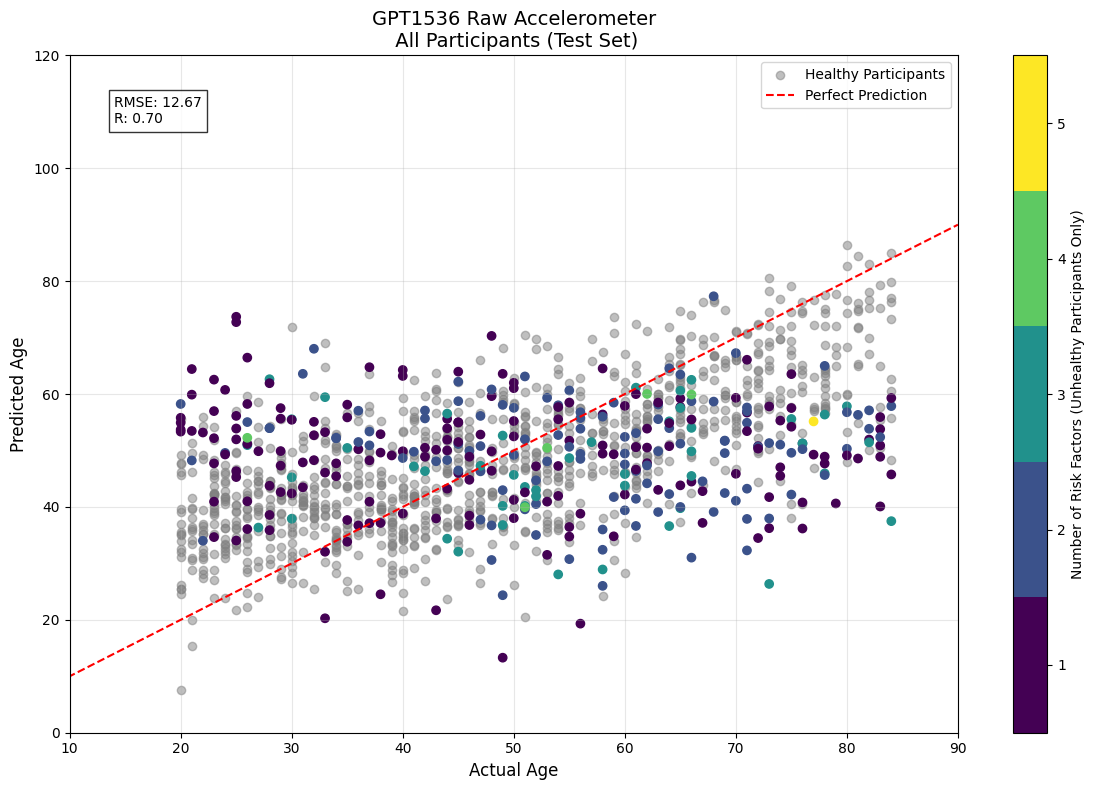


Prediction Statistics:
Mean Absolute Error: 10.15
Mean prediction: 48.93
Mean actual age: 48.68
Age range in test set: 20 to 84



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


GPT1536 OTC
RMSE for test set: 13.55
R Squared for test set: 0.65


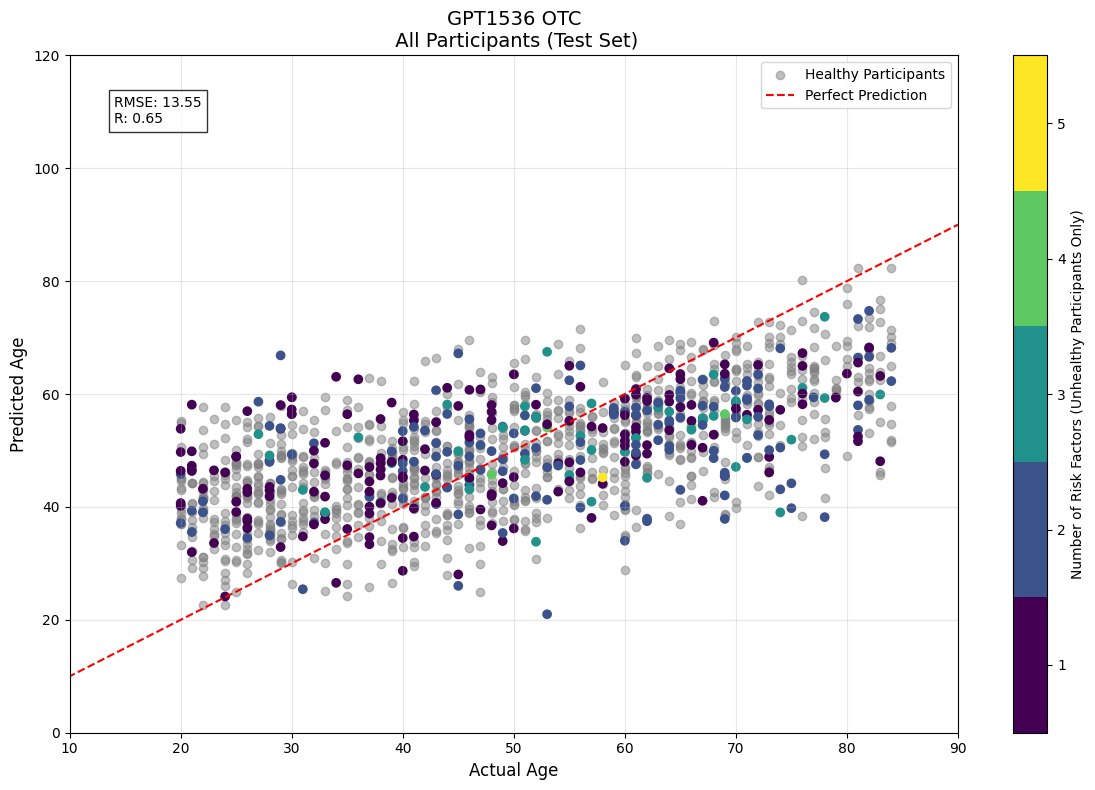


Prediction Statistics:
Mean Absolute Error: 11.07
Mean prediction: 49.49
Mean actual age: 49.39
Age range in test set: 20 to 84



In [110]:
for name, data in df_1536.items():
    X = data.drop(columns=["Age", 'SEQN'], errors="ignore")
    y = data["Age"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    test_seqns = data.loc[y_test.index, 'SEQN']
    matching_seqns = test_seqns[test_seqns.isin(unhealthy_participants['SEQN'])]
    
    test_n_risk = pd.Series(index=y_test.index, data=np.nan)
    unhealthy_n_risk = unhealthy_participants.set_index('SEQN')['n_risk']
    test_n_risk.loc[matching_seqns.index] = matching_seqns.map(unhealthy_n_risk)

    X_scaler = StandardScaler()

    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    ridge_1536 = RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True)
    ridge_1536.fit(X_train_scaled, y_train)
    y_pred_gpt1536 = ridge_1536.predict(X_test_scaled)
    rmse_gpt1536 = np.sqrt(mean_squared_error(y_test, y_pred_gpt1536))
    r_gpt1536 = stats.pearsonr(y_test, y_pred_gpt1536)[0]

    print(name)
    print(f"RMSE for test set: {rmse_gpt1536:.2f}")
    print(f"R Squared for test set: {r_gpt1536:.2f}")

    plt.figure(figsize=(12, 8))
    healthy_mask = test_n_risk.isna()
    plt.scatter(y_test[healthy_mask], y_pred_gpt1536[healthy_mask], 
               alpha=0.5, c='gray', label='Healthy Participants')
    
    # Then plot unhealthy participants with n_risk colors
    unhealthy_mask = ~healthy_mask
    scatter = plt.scatter(y_test[unhealthy_mask], y_pred_gpt50[unhealthy_mask], 
                        c=test_n_risk[unhealthy_mask], 
                         cmap='viridis')
    
    plt.colorbar(scatter, label='Number of Risk Factors (Unhealthy Participants Only)',boundaries=np.arange(0.5, 5 + 1.5, 1),
                    ticks=np.arange(0, 5 + 1, 1))
    
    plt.plot([0, 90], [0, 90], 'r--', label='Perfect Prediction')
    plt.xlim(10, 90)
    plt.ylim(0, 120)
    plt.xlabel('Actual Age', fontsize=12)
    plt.ylabel('Predicted Age', fontsize=12)
    plt.title(f'{name}\n All Participants (Test Set)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    metrics_text = f'RMSE: {rmse_gpt1536:.2f}\nR: {r_gpt1536:.2f}'
    plt.text(0.05, 0.9, metrics_text, transform=plt.gca().transAxes, 
            bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nPrediction Statistics:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_gpt1536):.2f}")
    print(f"Mean prediction: {y_pred_gpt1536.mean():.2f}")
    print(f"Mean actual age: {y_test.mean():.2f}")
    print(f"Age range in test set: {y_test.min():.0f} to {y_test.max():.0f}\n")